# Una red neuronal básica con datos de renta de bicicletas.

En este proyecto, se construirá una red neuronal y se usará para predecir el número de usuarios que alquilan bicicletas. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Carga y preparación de los datos

Un paso crítico en el trabajo con redes neuronales es preparar los datos correctamente. Las variables en diferentes escalas dificultan que la red aprenda eficientemente los pesos correctos. A continuación, escribimos el código para cargar y preparar los datos.

In [6]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [7]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Verificando los datos

Este conjunto de datos tiene el número de pasajeros por cada hora de cada día desde el 1 de enero de 2011 hasta el 31 de diciembre de 2012. El número de pasajeros se divide entre casual y registrado, la suma de ambos esta en la columna `cnt`.

A continuación se muestra un gráfico que muestra el número de ciclistas en los primeros 10 días en el conjunto de datos. Puede ver los alquileres por hora aquí. ¡Esta información es bastante complicada! Los fines de semana tienen un número de pasajeros más bajo y hay picos cuando las personas van en bicicleta hacia y desde el trabajo durante la semana. Al observar los datos anteriores, también tenemos información sobre la temperatura, la humedad y la velocidad del viento, lo que probablemente afecte a la cantidad de pasajeros. Se intentarás capturar todo esto en el modelo.



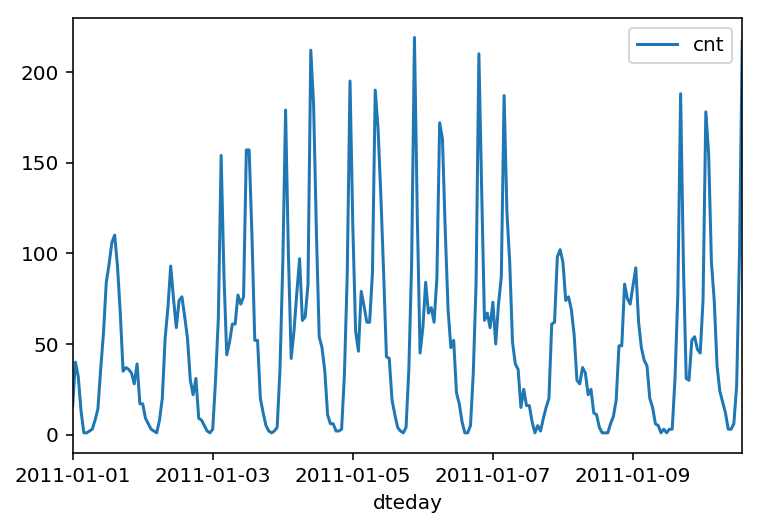

In [8]:
rides[:24*10].plot(x='dteday', y='cnt')

### Variables Dummy 

Aquí tenemos algunas variables categóricas como la estación, el clima y el mes. Para incluir estos en nuestro modelo, necesitaremos hacer variables dummy binarias. Esto es simple de hacer con Pandas gracias a `get_dummies ()`.


In [9]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Esclando las variables target

Para facilitar el entrenamiento de la red, estandarizaremos cada una de las variables continuas. Es decir, cambiaremos y escalaremos las variables de modo que tengan una media cero y una desviación estándar de 1.

Los factores de escala se guardan para que podamos retroceder cuando utilizamos la red para las predicciones.


In [10]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Dividir los datos en entrenamiento, prueba y validación

Guardaremos los últimos 21 días de los datos para usarlos como un conjunto de prueba, una vez que hayamos entrenado la red. Utilizaremos este conjunto para hacer predicciones y compararlas con el número real de pasajeros.

In [11]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

Dividiremos los datos en dos conjuntos, uno para entrenamiento y otro para validacion. Como se trata de datos de series de tiempo, entrenaremos sobre datos históricos, luego trataremos de predecir datos futuros (el conjunto de validación).

In [12]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Construcción de la Red Neuronal 

Below you'll build your network. We've built out the structure and the backwards pass. You'll implement the forward pass through the network. You'll also set the hyperparameters: the learning rate, the number of hidden units, and the number of training passes.

The network has two layers, a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$. A function that takes the input signal and generates an output signal, but takes into account the threshold, is called an activation function. We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to propagate signals forward from the input to the output layers in a neural network. We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

> **Hint:** You'll need the derivative of the output activation function ($f(x) = x$) for the backpropagation implementation. If you aren't familiar with calculus, this function is equivalent to the equation $y = x$. What is the slope of that equation? That is the derivative of $f(x)$.

Below, you have these tasks:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.
  

In [13]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.input_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5, 
                                       (self.output_nodes, self.hidden_nodes))
        self.lr = learning_rate
        
        #### Set this to your implemented sigmoid function ####
        # Activation function is the sigmoid function
        
        #self.activation_function = activation 
   
    def activation_function (self,x):
        return 1/(1+np.exp(-x))
    
    def train(self, inputs_list, targets_list):
        # Convert inputs list to 2d array
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin=2).T
        #### Implement the forward pass here ####
        ### Forward pass ###
        # TODO: Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden,inputs) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

        # TODO: Output layer
        final_inputs = np.dot(self.weights_hidden_to_output,hidden_outputs) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer
        
        #### Implement the backward pass here ####
        ### Backward pass ###
        
        # TODO: Output error
        output_errors = targets - final_outputs # Output layer error is the difference between desired target and actual output.
        #output_grad = output_errors * 1   # delta o

        # TODO: Backpropagated error
        #hidden_errors = output_errors # errors propagated to the hidden layer
        hidden_grad = hidden_outputs * (1 - hidden_outputs) # hidden layer gradients, delta h
        hidden_errors = np.dot(self.weights_hidden_to_output.T,output_errors) 
        
        # Delta weights
        
        delta_w_h_o = self.lr * np.dot(output_errors, hidden_outputs.T)
        delta_w_i_h = self.lr * hidden_errors * hidden_grad * inputs.T
        
        # TODO: Update the weights
        self.weights_hidden_to_output += delta_w_h_o # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += delta_w_i_h # update input-to-hidden weights with gradient descent step

    def run(self, inputs_list):
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        #### Implement the forward pass here ####
        # TODO: Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden,inputs) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

        # TODO: Output layer
        final_inputs = np.dot(self.weights_hidden_to_output,hidden_outputs) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer
        
        return final_outputs

In [14]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training the network

Here you'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but you're not overfitting to the data. If you train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

You'll also be using a method know as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently. You'll learn more about SGD later.

### Choose the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. You'll need to choose enough epochs to train the network well but not too many or you'll be overfitting.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

In [15]:
import sys

### Set the hyperparameters here ###
epochs = 250
learning_rate = 0.1
hidden_nodes = 25
output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, 
                              train_targets.ix[batch]['cnt']):
        network.train(record, target)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
    sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4] \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 99.6% ... Training loss: 0.092 ... Validation loss: 0.187

(0.023482221946267201, 1.5)

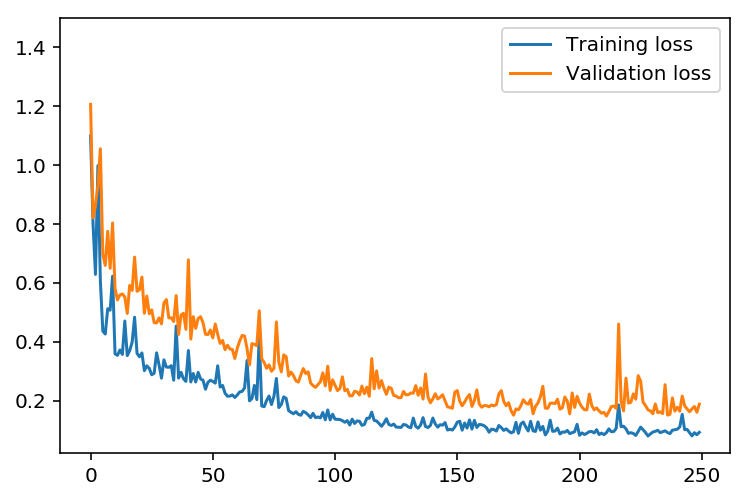

In [16]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
plt.ylim(ymax=1.5)

## Check out your predictions

Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

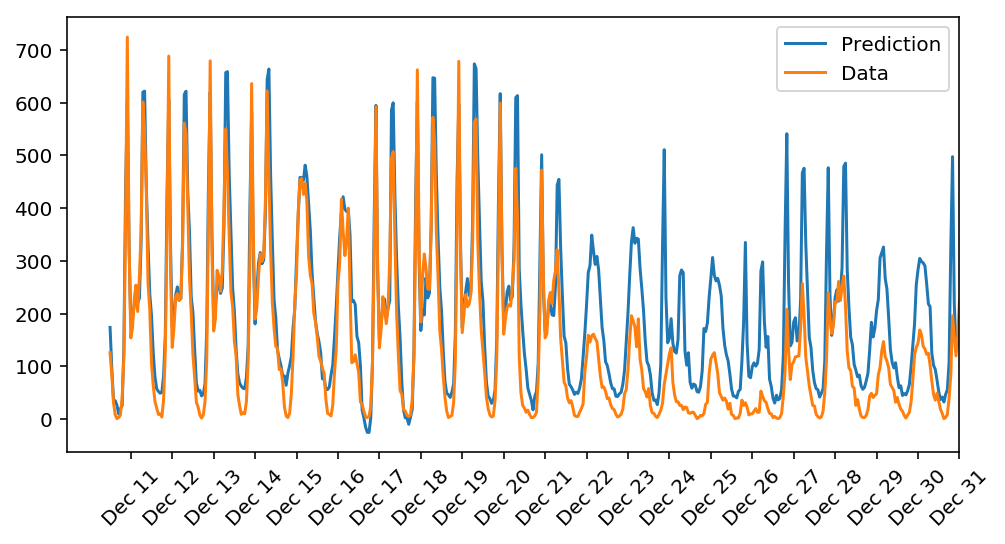

In [17]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

## Thinking about your results
 
How well does the model predict the data? Where does it fail? Why does it fail where it does?
